# Node-centric expression models (NCEM)

## [Learning cell communication from spatial graphs of cells](https://www.biorxiv.org/content/10.1101/2021.07.11.451750v1) (Fischer, Schaar, Theis, 2021)

![title](https://raw.githubusercontent.com/theislab/ncem/main/docs/_static/img/concept.png)


## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import ncem
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.set_figure_params(dpi=80)

import warnings
warnings.filterwarnings("ignore")

## Data directory

In [2]:
# data path
path = '/storage/groups/ml01/workspace/anna.schaar/tissue/'

In [3]:
nc_inter = ncem.interpretation.interpreter.InterpreterInteraction()
nc_inter.get_data(
    data_origin='hartmann',
    data_path=path + '/data/hartmann/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', nc_inter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|█████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 38.98it/s]

Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036

 Celldata metadata: {'lateral_resolution': 0.390625, 'fn': ['scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv', 'scMEP_sample_description.xlsx'], 'image_col': 'point', 'pos_cols': ['center_colcoord', 'center_rowcoord'], 'cluster_col': 'Cluster', 'cluster_col_preprocessed': 'Cluster_preprocessed', 'patient_col': 'donor'}


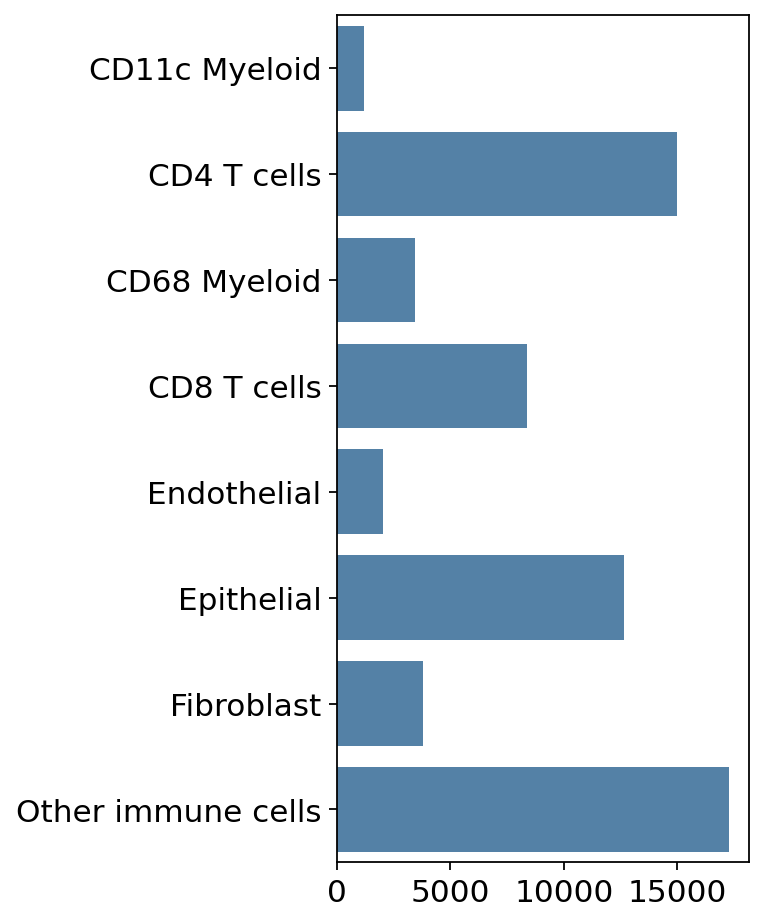

In [4]:
nc_inter.data.celltype_frequencies()

0.0
1.000547499859607
10.193272571484671
128.1181909355233
1071.8057746883462


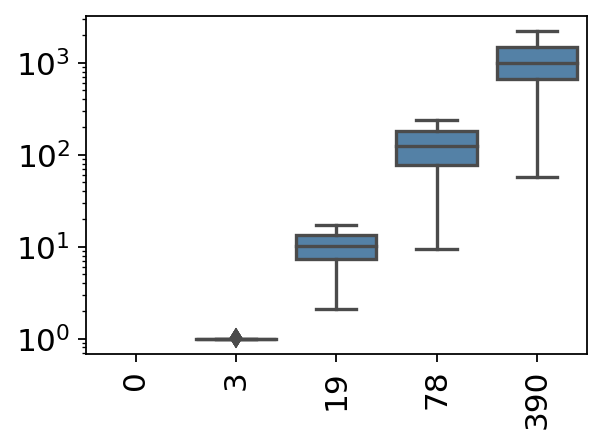

In [5]:
nc_inter.data.plot_degree_vs_dist(
    max_distances=[0, 10, 50, 200, 1000],
    lateral_resolution=400/1024,
)

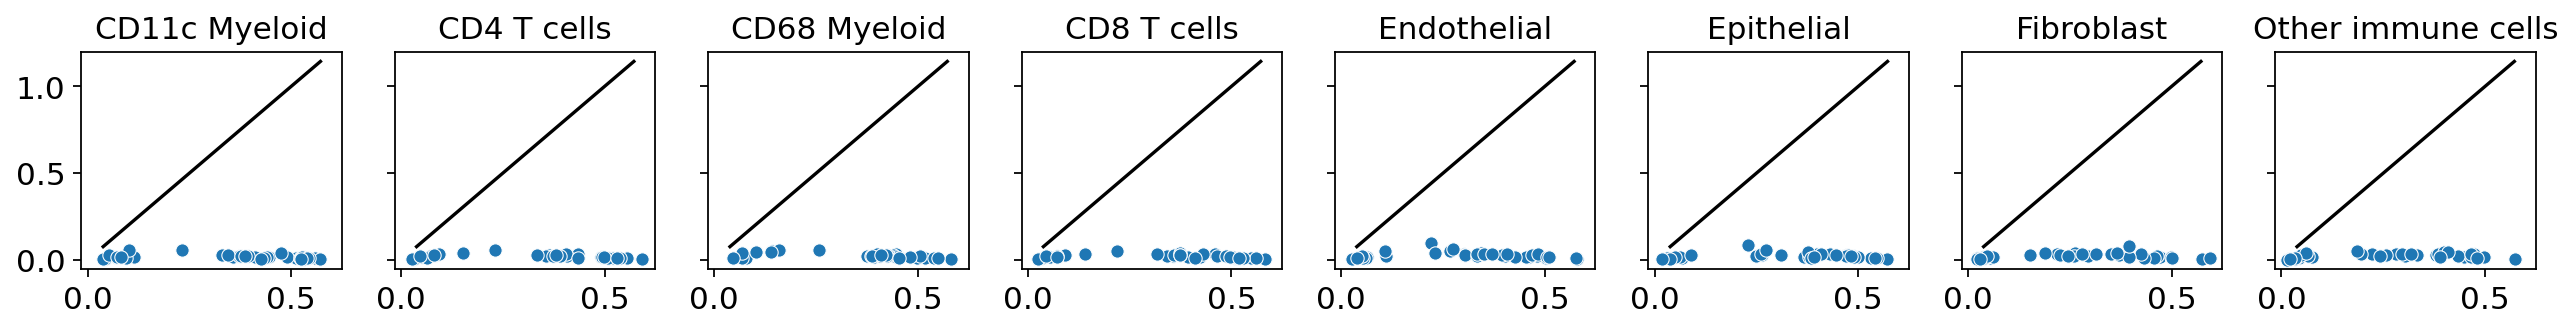

In [6]:
nc_inter.data.noise_structure()

  0%|                                                                                   | 0/2 [00:00<?, ?it/s]

210419_INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1_HARTMANN: loaded 1 runs with 3-fold cross validation


 50%|█████████████████████████████████████                                     | 1/2 [03:57<03:57, 237.54s/it]

210419_INTERACTIONS_MAX_NODES_IMAGE_1_HARTMANN: loaded 24 runs with 3-fold cross validation
210419_interactions_baseline_none_nodes_image_1_hartmann_adam_lr1_agrFalse_predecTrue_bsS_md0_tk4_n10_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l1N_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21
210419_interactions_max_nodes_image_1_hartmann_adam_lr1_agrFalse_predecTrue_bsS_md0_tk4_n10_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l1N_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21
subset was empty, available values for model are ['INTERACTIONS_MAX_NODES_IMAGE_1'], given was ['INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1']
None
210419_interactions_max_nodes_image_1_hartmann_adam_lr1_agrFalse_predecTrue_bsS_md1_tk4_n10_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l1N_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21
subset was empty, available values for model are ['INTERACTIONS_MAX_NODES_IMAGE_1'], given was ['INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1']
None
210419_interactions_max_nodes_image_1_hartmann_adam_lr1_agrFalse_predecTrue_bsS_md2

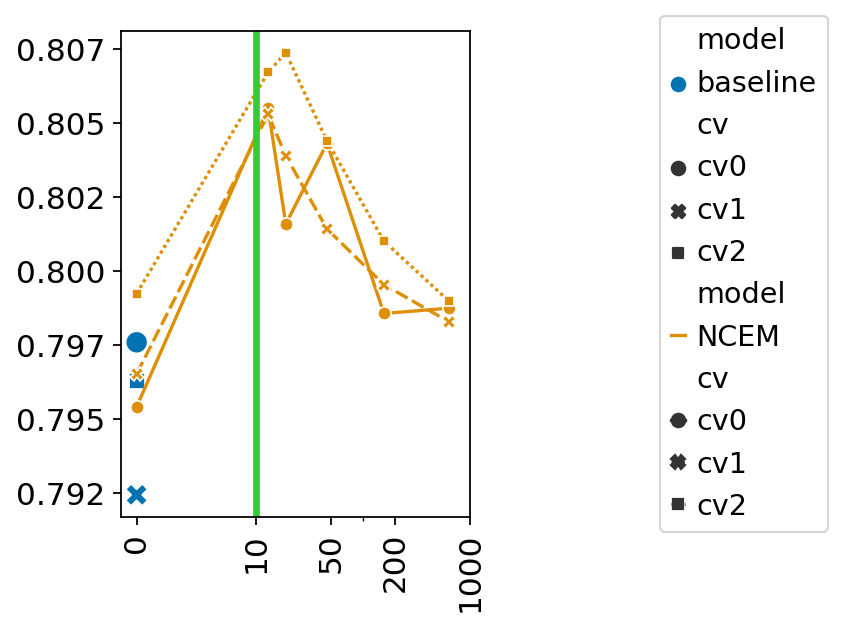

In [7]:
nc_gs = ncem.train.GridSearchContainer(
    path + '/grid_searches_gen/', 
    gs_ids=[
        "210419_INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1_HARTMANN",
        "210419_INTERACTIONS_MAX_NODES_IMAGE_1_HARTMANN",
    ],
    lateral_resolution = 400/1024
)
nc_gs.load_gs()

nc_gs.plot_best_model_by_hyperparam(
    graph_model_class='interactions',
    baseline_model_class='interactions_baseline',
    rename_levels = [
        ("model", {
            "INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1": "baseline",
            "INTERACTIONS_MAX_NODES_IMAGE_1": "NCEM",
        })
    ],
    xticks=[0, 10, 50, 200, 1000],
)

In [8]:
# splitting data into test and validation sets, can be ignored for non sender-receiver focused analysis
nc_inter.split_data_node(0.1, 0.1)
nc_inter.n_eval_nodes_per_graph = 10
nc_inter.cell_names = list(nc_inter.data.celldata.uns['node_type_names'].values())

Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51914 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 



In [9]:
nc_inter.get_sender_receiver_effects()

100%|███████████████████████████████████████████████████████████████████▊| 6351/6374 [00:35<00:00, 178.75it/s]


using ols parameters.
calculating inv fim.


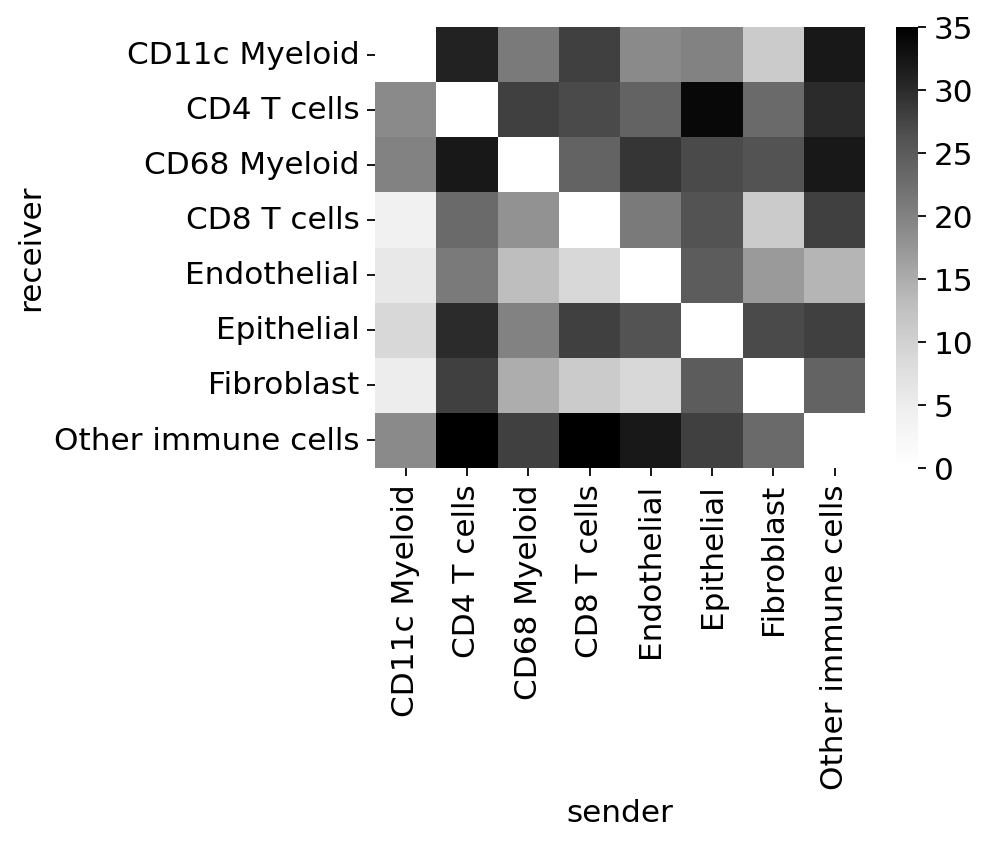

In [10]:
nc_inter.type_coupling_analysis(figsize=(6.5, 5.5))

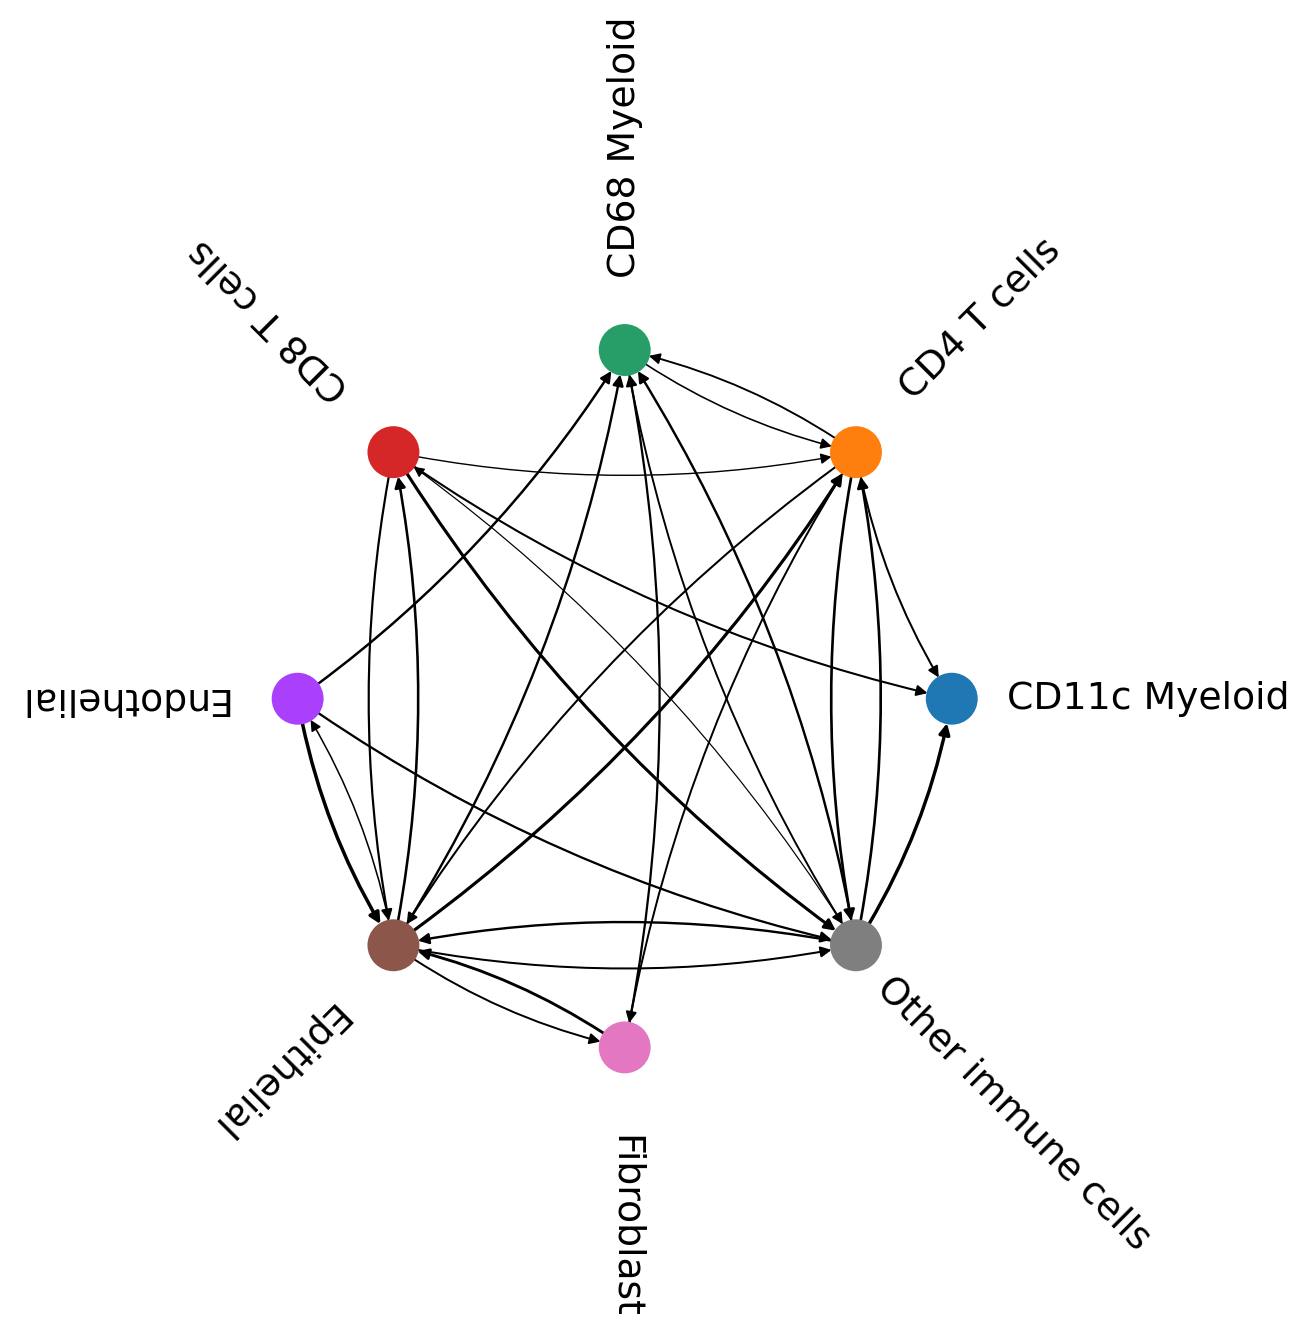

In [11]:
nc_inter.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)

In [12]:
nc_inter.sender_receiver_values(receiver='CD8 T cells', sender='Epithelial').sort_values(by='fold change', ascending=False).head(5)

,mean expression,pvalue,qvalue,fold change
PTPRC,0.751001,0.000000e+00,0.000000e+00,0.173297
RPS6,0.452072,0.000000e+00,0.000000e+00,0.104350
HK1,0.625943,0.000000e+00,0.000000e+00,0.099149
XBP1,0.243841,5.391021e-09,1.477117e-08,0.082731
CD8A,0.536345,5.055689e-11,1.550810e-10,0.079032


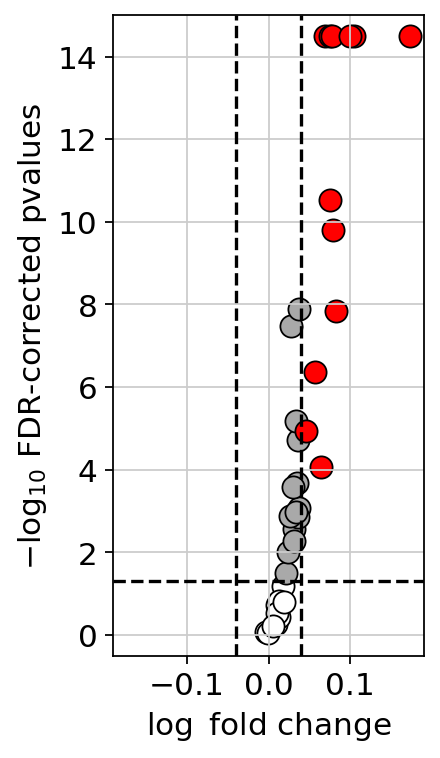

In [13]:
nc_inter.sender_receiver_effect_vulcanoplot(
    receiver='CD8 T cells', 
    sender='Epithelial',
    fold_change_threshold=0.04,
    figsize=(3,5)
)

In [14]:
nc_inter.sender_receiver_values(sender='CD8 T cells', receiver='Epithelial').sort_values(by='fold change').head(5)

,mean expression,pvalue,qvalue,fold change
CD247,0.033484,0.000763,0.001416,-0.052485
CD4,0.443922,0.001464,0.002639,-0.033691
PTPRC,0.092476,0.084400,0.118958,-0.028595
PECAM1,0.019289,0.629176,0.687531,-0.004426
LDHA,0.631155,0.669940,0.723233,-0.003232


In [15]:
nc_inter.sender_receiver_values(sender='CD8 T cells', receiver='Epithelial').sort_values(by='fold change', ascending=False).head(5)

,mean expression,pvalue,qvalue,fold change
ATP1A1,0.601786,0.000000e+00,0.000000e+00,0.102429
SLC1A5,0.617981,0.000000e+00,0.000000e+00,0.098477
SLC3A2,0.458504,8.881784e-16,3.385527e-15,0.098253
CKM,0.491795,2.913225e-12,9.619210e-12,0.084243
CDH1,0.538660,2.060574e-13,7.207838e-13,0.075619


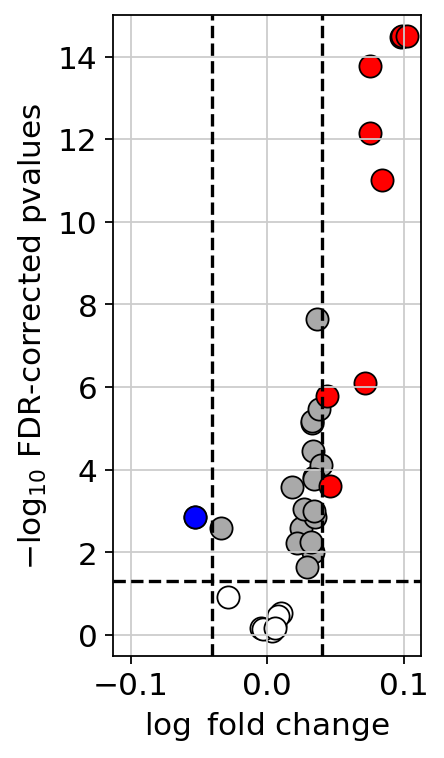

In [16]:
nc_inter.sender_receiver_effect_vulcanoplot(
    sender='CD8 T cells', 
    receiver='Epithelial',
    fold_change_threshold=0.04,
    figsize=(3,5)
)

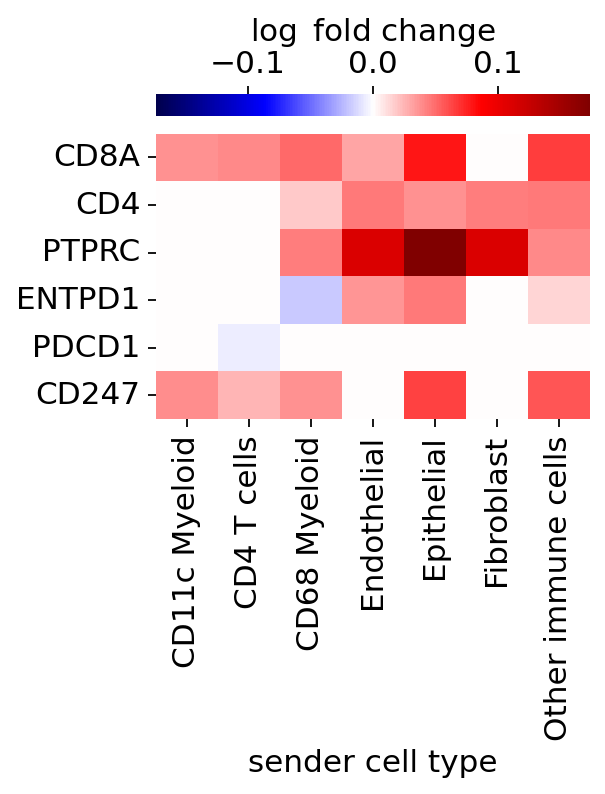

In [17]:
nc_inter.sender_effect(
    receiver='CD8 T cells', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

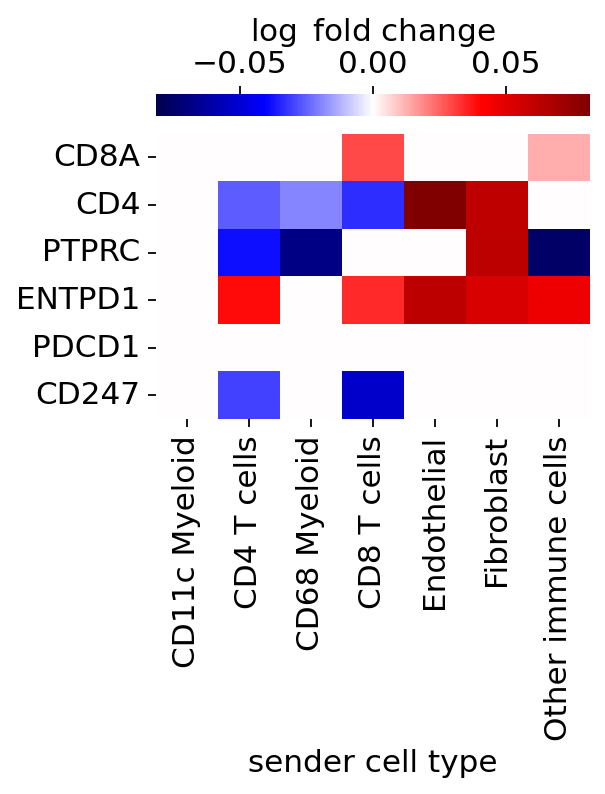

In [18]:
nc_inter.sender_effect(
    receiver='Epithelial', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)